<a href="https://colab.research.google.com/github/bshazia/Apple_Stocks/blob/main/Apple_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!pip install yfinance==0.2.12

**Step 1: Data Collection**

In [92]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import datetime

In [37]:
#daily data for past 10 years
data_daily_copy = yf.download("AAPL", period="10y", interval="1d")
data_daily_copy.to_csv('AAPL_daily_data.csv')

#monthly data for past 10 years
data_monthly = yf.download("AAPL", period="10y", interval="1mo")
data_monthly.to_csv('AAPL_monthly_data.csv')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [38]:
data_daily_copy.sample(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-06-20,50.092499,50.152500,49.507500,49.865002,48.124577,86056000
2024-01-10,184.350006,186.399994,183.919998,186.190002,185.700836,46792900
2019-07-19,51.447498,51.625000,50.590000,50.647499,48.879753,83717200
2016-06-13,24.672501,24.780001,24.275000,24.334999,22.351372,152082000
2019-10-10,56.982498,57.610001,56.825001,57.522499,55.725727,113013600


Step 2: Data Preprocessing

In [39]:
data_daily_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-08-08 to 2024-08-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2517 non-null   float64
 1   High       2517 non-null   float64
 2   Low        2517 non-null   float64
 3   Close      2517 non-null   float64
 4   Adj Close  2517 non-null   float64
 5   Volume     2517 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


In [40]:
#remove one week
one_week_ago = datetime.date.today() - datetime.timedelta(days=7)

data_daily = data_daily_copy[data_daily_copy.index < pd.Timestamp(one_week_ago)]

data_daily.to_csv('AAPL_data_daily_Week_back.csv')

In [20]:
data_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2014-09-01 to 2024-08-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       120 non-null    float64
 1   High       120 non-null    float64
 2   Low        120 non-null    float64
 3   Close      120 non-null    float64
 4   Adj Close  120 non-null    float64
 5   Volume     120 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 6.6 KB


In [41]:
# Check for missing dates in daily data
all_dates_daily = pd.date_range(start=data_daily.index.min(), end=data_daily.index.max(), freq='D')
missing_dates_daily = all_dates_daily.difference(data_daily.index)
print("Missing dates in daily data:", missing_dates_daily)
print("Number of missing dates in daily data:", missing_dates_daily.size)

# Check for missing dates in monthly data
all_dates_monthly = pd.date_range(start=data_monthly.index.min(), end=data_monthly.index.max(), freq='M')
missing_dates_monthly = all_dates_monthly.difference(data_monthly.index)
print("Missing dates in monthly data:", missing_dates_monthly)
print("Number of missing dates in monthly data:", missing_dates_monthly.size)

Missing dates in daily data: DatetimeIndex(['2014-08-09', '2014-08-10', '2014-08-16', '2014-08-17',
               '2014-08-23', '2014-08-24', '2014-08-30', '2014-08-31',
               '2014-09-01', '2014-09-06',
               ...
               '2024-06-30', '2024-07-04', '2024-07-06', '2024-07-07',
               '2024-07-13', '2024-07-14', '2024-07-20', '2024-07-21',
               '2024-07-27', '2024-07-28'],
              dtype='datetime64[ns]', length=1135, freq=None)
Number of missing dates in daily data: 1135
Missing dates in monthly data: DatetimeIndex(['2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30',
               ...
               '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31',
               '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31',
               '2024-06-30', '2024-07-31'],
              dtype='datetime64[ns]', length=119, freq

In [42]:
#lets verify it with market calendar
!pip install pandas_market_calendars
import pandas_market_calendars as mcal

nyse = mcal.get_calendar('NYSE')

trading_days = nyse.schedule(start_date=data_daily.index.min(), end_date=data_daily.index.max())

non_trading_days = missing_dates_daily[~missing_dates_daily.isin(trading_days.index)]

print("Number of missing dates that are non-trading days:", non_trading_days.size)

Number of missing dates that are non-trading days: 1135


these are non-trading days and it's not impacting our data


In [65]:
# Previous day's closing price
data_daily['Close_Lag1'] = data_daily['Close'].shift(1)

data_daily['Close_MA5'] = data_daily['Close'].rolling(window=5).mean()


<ipython-input-65-180fcf9dbae1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_daily['Close_Lag1'] = data_daily['Close'].shift(1)
<ipython-input-65-180fcf9dbae1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_daily['Close_MA5'] = data_daily['Close'].rolling(window=5).mean()


In [66]:
# Calculate 5-day SMA
data_daily['SMA_5_'] = data_daily['Close'].rolling(window=5).sum() / 5

<ipython-input-66-5380d68c20d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_daily['SMA_5_'] = data_daily['Close'].rolling(window=5).sum() / 5


In [67]:
# last day closing price

data_daily['Close_Lag1'] = data_daily['Close'].shift(1)
data_daily['Close_Lag1'].tail(5)

<ipython-input-67-29ca3991b7f6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_daily['Close_Lag1'] = data_daily['Close'].shift(1)


,Close_Lag1
Date,
2024-07-25,218.539993
2024-07-26,217.490005
2024-07-29,217.960007
2024-07-30,218.240005
2024-07-31,218.800003


In [68]:
data_daily['SMA_5_'].tail(5)

,SMA_5_
Date,
2024-07-25,221.862000
2024-07-26,220.592001
2024-07-29,219.448001
2024-07-30,218.206003
2024-07-31,218.914005


**Training**

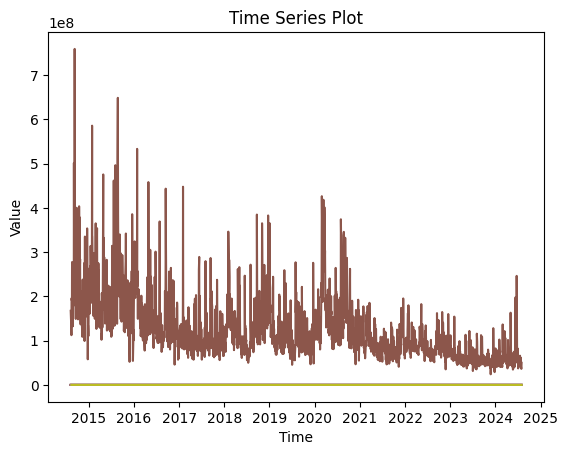

In [69]:
#checking for trend
import matplotlib.pyplot as plt

plt.plot(data_daily)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.show()

In [70]:
features = ['Close_Lag1', 'Close_MA5', 'SMA_5_', 'Open',	'High'	,'Low']

#features = ['Close_Lag1', 'Close_MA5']

# features = ['Close_Lag1', 'Close_MA5', 'SMA_5_']


x = data_daily[features]
y = data_daily['Close'][x.index]

In [71]:
# Handle missing values (due to lagged features)
x = x.dropna()
y = y[x.index]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)


In [72]:
X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])


In [73]:
model_lstm = Sequential()
model_lstm.add(LSTM(70, input_shape=(1, X_train.shape[1])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [81]:
data_daily.shape


(2511, 9)

In [82]:
model_lstm.fit(X_train_lstm, y_train, epochs=150, batch_size=64)


Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 248.1187
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 262.5296
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 236.1747 
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 237.1552
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 241.4135
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 217.0855
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 223.7151
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 214.2263
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 202.9571
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 214.7811
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 186.7909
Epoch 12/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 195.7812
Epoch 13/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 198.4186
Epoch 14/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 183.5762
Epoch 15/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0

**Evaluation**

In [83]:
y_pred_lstm = model_lstm.predict(X_test_lstm)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [84]:
mse_lstm = mean_squared_error(y_test, y_pred_lstm.flatten())
rmse_lstm = mean_squared_error(y_test, y_pred_lstm.flatten(), squared=False)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm.flatten())

print("LSTM - MSE:", mse_lstm, "RMSE:", rmse_lstm, "MAE:", mae_lstm)

LSTM - MSE: 362.0241006155393 RMSE: 19.026930930014416 MAE: 13.762737562931866


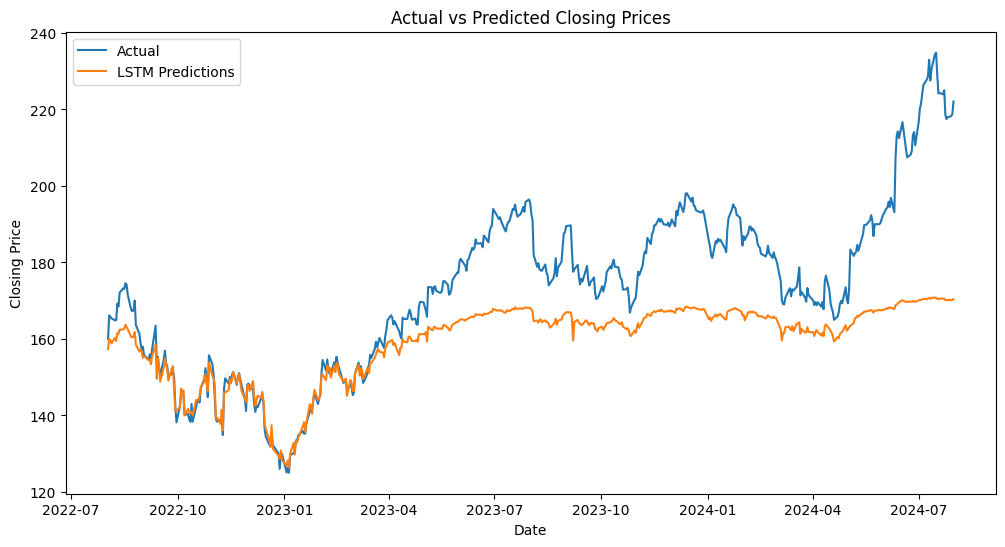

In [85]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_lstm, label='LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

cheking with prophit now

In [93]:
df_train = pd.DataFrame({'ds': X_train.index, 'y': y_train})
df_test = pd.DataFrame({'ds': X_test.index, 'y': y_test})

In [94]:
model_prophet = Prophet()
model_prophet.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7i42gpb9/qjh65kfb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7i42gpb9/a01dyr6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11597', 'data', 'file=/tmp/tmp7i42gpb9/qjh65kfb.json', 'init=/tmp/tmp7i42gpb9/a01dyr6n.json', 'output', 'file=/tmp/tmp7i42gpb9/prophet_model_tp71xds/prophet_model-20240808173855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [95]:
future = model_prophet.make_future_dataframe(periods=len(df_test))
forecast = model_prophet.predict(future)
y_pred_prophet = forecast['yhat'][-len(df_test):]

In [96]:

mse_prophet = mean_squared_error(y_test, y_pred_prophet)
rmse_prophet = mean_squared_error(y_test, y_pred_prophet, squared=False)
mae_prophet = mean_absolute_error(y_test, y_pred_prophet)

print("Prophet - MSE:", mse_prophet, "RMSE:", rmse_prophet, "MAE:", mae_prophet)

Prophet - MSE: 438.64063927673794 RMSE: 20.94374940827783 MAE: 17.20482735151628


now let's compare them

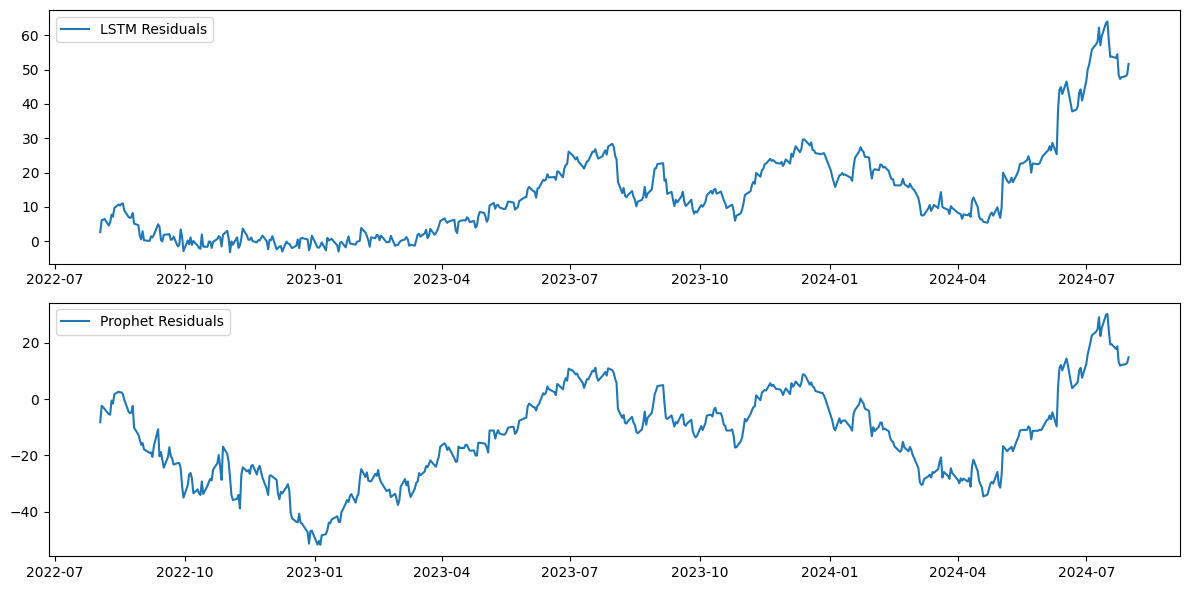

In [97]:
y_test_aligned = y_test.reset_index(drop=True)
y_pred_prophet_aligned = y_pred_prophet.reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(y_test.index, y_test - y_pred_lstm.flatten(), label='LSTM Residuals')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y_test.index, y_test_aligned - y_pred_prophet_aligned, label='Prophet Residuals')
plt.legend()
plt.tight_layout()
plt.show()

Let's compare it with actual values

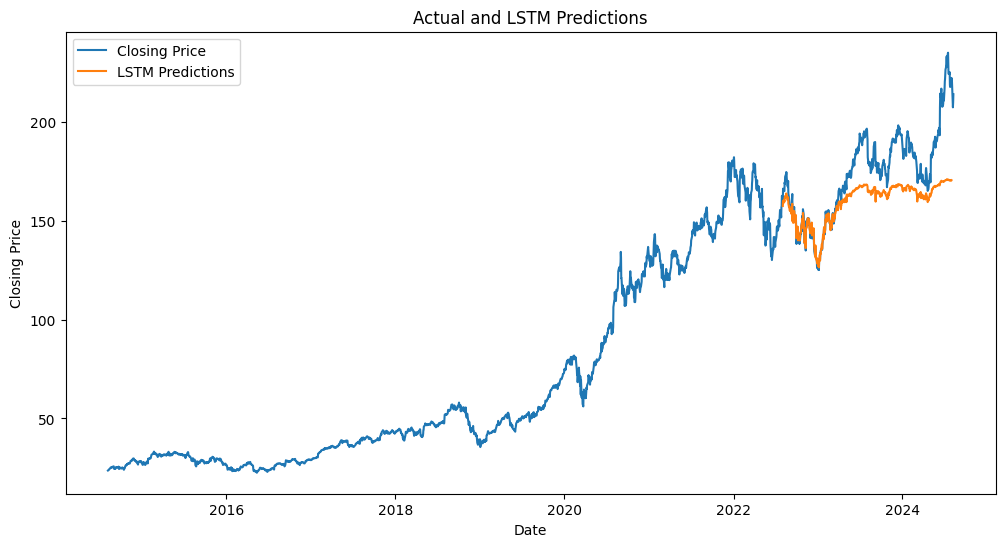

In [99]:
plt.figure(figsize=(12, 6))

#original data
plt.plot(data_daily_copy.index, data_daily_copy['Close'], label='Closing Price')

#trained Data
plt.plot(y_test.index, y_pred_lstm, label='LSTM Predictions')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual and LSTM Predictions')
plt.legend()
plt.show()